In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
%matplotlib nbagg

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from libertem import api
from libertem.job.raw import PickFrameJob
from libertem.common.slice import Slice

In [4]:
ctx = api.Context()

In [5]:
ds = ctx.load(
    "raw",
    path='C:\\Users\\weber\\ownCloud\\Projects\\Open Pixelated STEM framework\\Data\\EMPAD\\scan_11_x256_y256.raw',
    dtype="float32",
    scan_size=(256, 256),
    detector_size_raw=(130, 128),
    crop_detector_to=(128, 128),
)
(scan_y, scan_x, detector_y, detector_x) = ds.shape
mask_shape = (detector_y, detector_x)

In [6]:
def airy(center, scale, a, b, c):
    (x, y) = center
    (y_coords, x_coords) = np.mgrid[0:mask_shape[0], 0:mask_shape[1]]
    q = scale*np.sqrt((y_coords - y)**2 + (x_coords - x)**2)
    airy = np.sin(a*q**2 + b*q**4)*np.exp(-c*q)
    return airy

def airy_sample():
    return airy((64, 64), 0.5, 0.1, 0, 0.1)

def mk_airy(center, scale, a, b, c):
    return lambda : airy(center, scale, a, b, c)

def airy_list():
    result = []
    center = (64, 64)
    for scale in (0.1, 0.05, 0.01):
        for a in (-2, -0.2, -0.02, 0, 0.02, 0.2, 2):
            for b in (-2, -0.2, -0.02, 0, 0.02, 0.2, 2):
                for c in (0.01,):
                    result.append(mk_airy(center, scale, a, b, c))
    return result                

l = airy_list()

In [7]:
job = ctx.create_mask_job(factories=l, dataset=ds)

In [8]:
%%time
result = ctx.run(job)

Wall time: 33.2 s


<IPython.core.display.Javascript object>


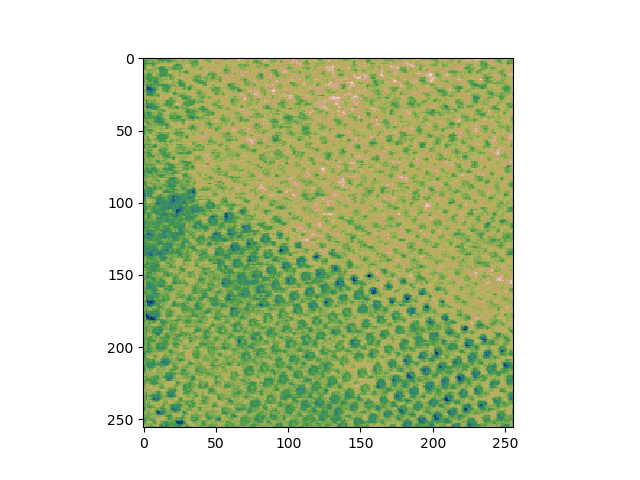

<IPython.core.display.Javascript object>


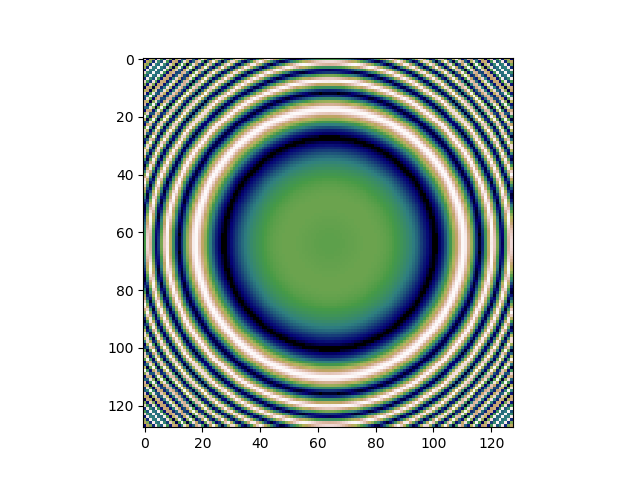

In [9]:
def show(i):
    fig, axes = plt.subplots()
    axes.imshow(result[i], cmap=cm.gist_earth)
    fig, axes = plt.subplots()
    axes.imshow(l[i](), cmap=cm.gist_earth)

show(85)
